# Loading Libraries
- https://www.kaggle.com/code/oscarm524/ps-s3-ep16-eda-modeling-submission/notebook

In [27]:
pip install catboost

In [64]:
pip install sklego

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=5185039ec11b415d36afc93e27e4e24cd85b8fa37a3457afd9bc65e7215823ea
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=f18a416ebd5c686bc0e2becfeeabcedfadac620479415afa503062fefd607350
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklego.linear_model import LADRegression

In [29]:
# !sudo apt-get install -y fonts-nanum

# Reading Data Files

In [30]:
train = pd.read_csv('train.csv')
original = pd.read_csv('CrabAgePrediction.csv')

test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [31]:
print('train data size : ', train.shape)
print('test data size : ', test.shape)
print('submission data size : ', submission.shape)

train data size :  (74051, 10)
test data size :  (49368, 9)
submission data size :  (49368, 2)


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [33]:
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [34]:
train.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [35]:
original.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


### 결측치 없음

# Data Description
- Sex: Gender of the Crab - Male, Female and Indeterminate
- Length: Length of the Crab in feet
- Diameter: Diameter of the Crab in feet
- Height: Height of the Crab in feet
- Weight: Weight of the Crab in ounces
- Shucked Weight: Weight without the shell in ounces
- Viscera Weight: Weight that wraps around the crab's abdominal organs in ounces
- Shell Weight: Weight of the Shell in ounces
- Age: Age of the Crab in months

# Data Exploration

### 데이터 중복 확인 =>> 없음

In [36]:
print(f'There are {train.shape[0]} observations in the train dataset')
print('There are', train.drop(columns=['id'], axis = 1).drop_duplicates().shape[0], 'unique observations in the train dataset')
print('There are', train.drop(columns=['id', 'Age'], axis = 1).drop_duplicates().shape[0], 'unique observations (only features) in the trian dataset')

There are 74051 observations in the train dataset
There are 74051 unique observations in the train dataset
There are 74051 unique observations (only features) in the trian dataset


In [37]:
print('There are', test.shape[0], 'observations in the train dataset')
print('There are', test.drop(columns=['id'], axis = 1).drop_duplicates().shape[0], 'unique observations (only features) in the trian dataset')

There are 49368 observations in the train dataset
There are 49368 unique observations (only features) in the trian dataset


### train, original 데이터 분포와 상관계수 확인

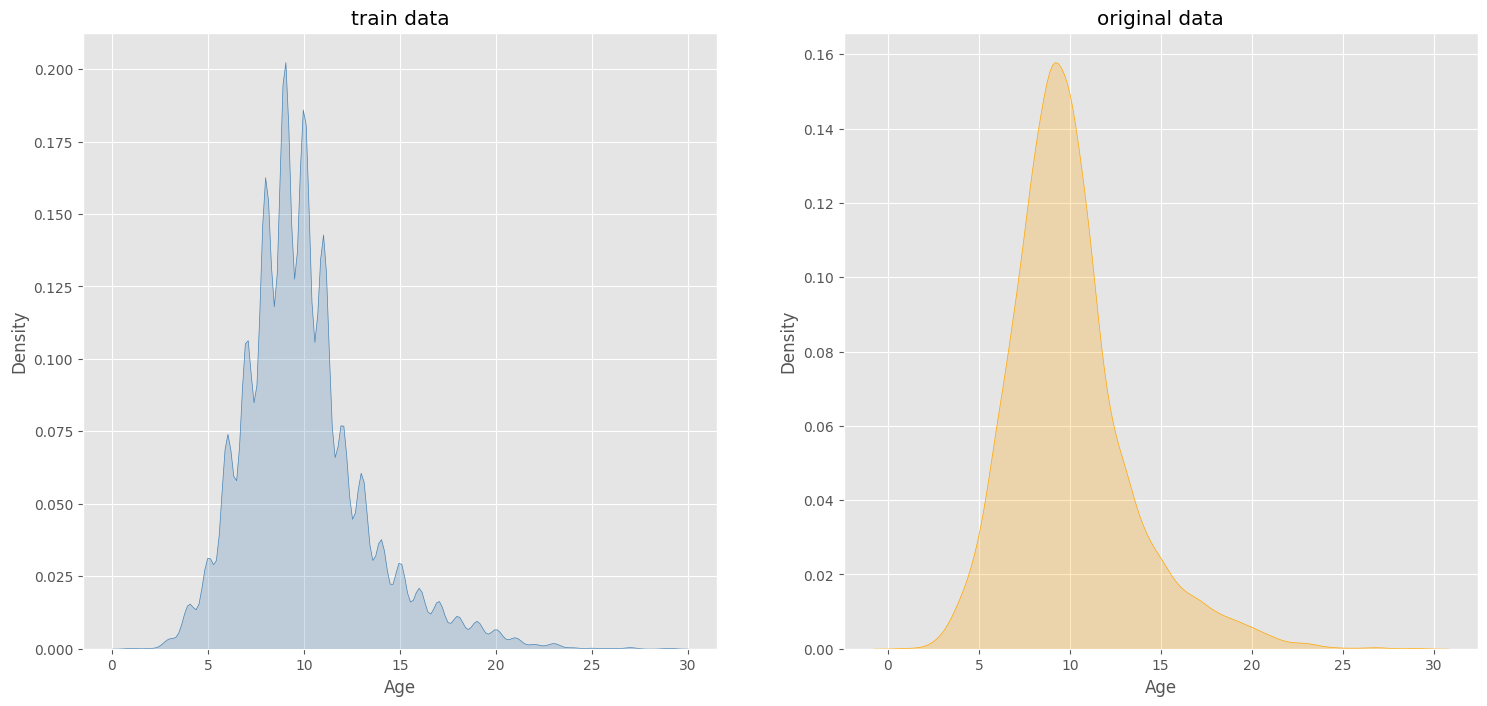

In [38]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.kdeplot(ax = axes[0], data = train, x = 'Age', fill = True, color = 'steelblue').set_title('train data');
sns.kdeplot(ax = axes[1], data = original, x = 'Age', fill = True, color = 'orange').set_title('original data');
plt.show()

- train 데이터와 원본 데이터에 분포상 큰 차이가 없는 것으로 보임

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from

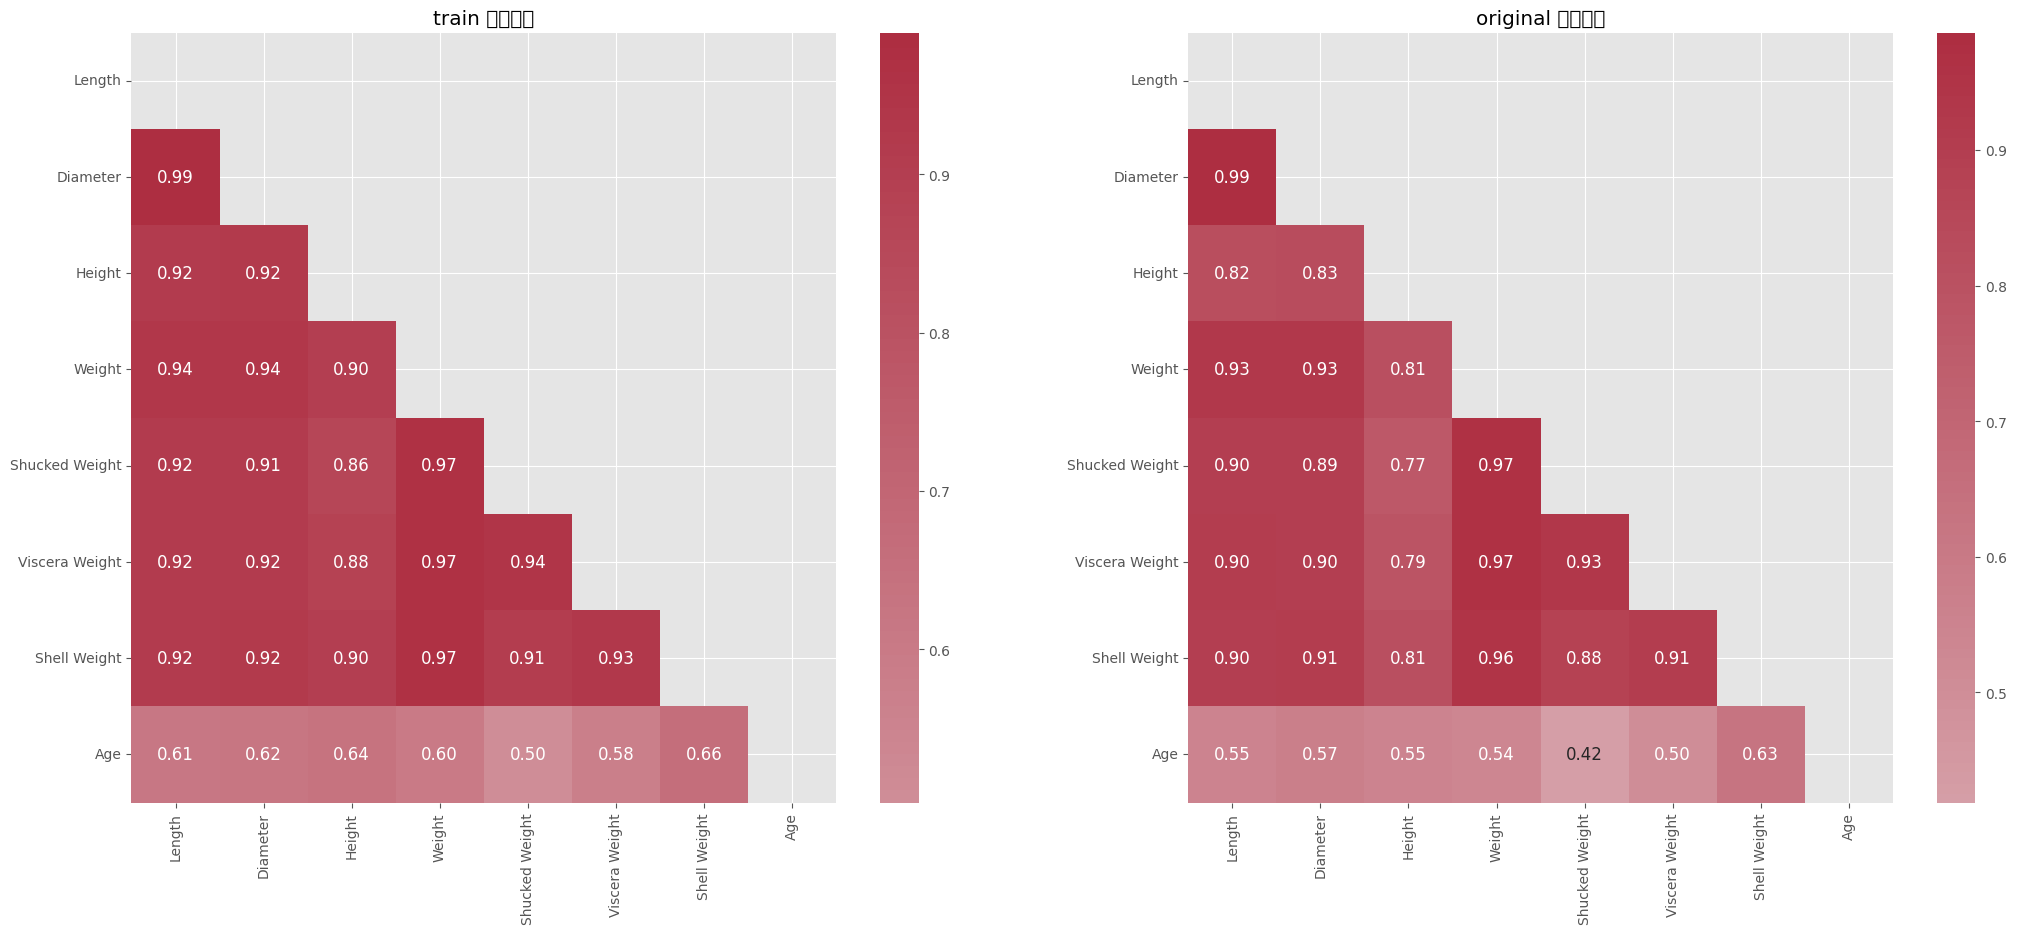

In [39]:
corr_train = train.drop(columns = ['id', 'Sex'], axis = 1).corr()
corr_original = original.drop(columns = ['Sex'], axis = 1).corr()

train_mask = np.triu(np.ones_like(corr_train, dtype = bool))
original_mask = np.triu(np.ones_like(corr_original, dtype = bool))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)

fig, axes = plt.subplots(1, 2, figsize = (25, 10))
sns.heatmap(corr_train, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size':12}, ax = axes[0], mask = train_mask).set_title('train 상관관계')

sns.heatmap(corr_original, annot = True, cmap = cmap, fmt = '.2f', center = 0,
           annot_kws = {'size':12}, ax = axes[1], mask = original_mask).set_title('original 상관관계')

plt.show()

- age와 shell weight의 상관계수가 가장 높음
- age 와 shucked weight의 상관계수가 가장 낮음

### sex, age 관계 살피기

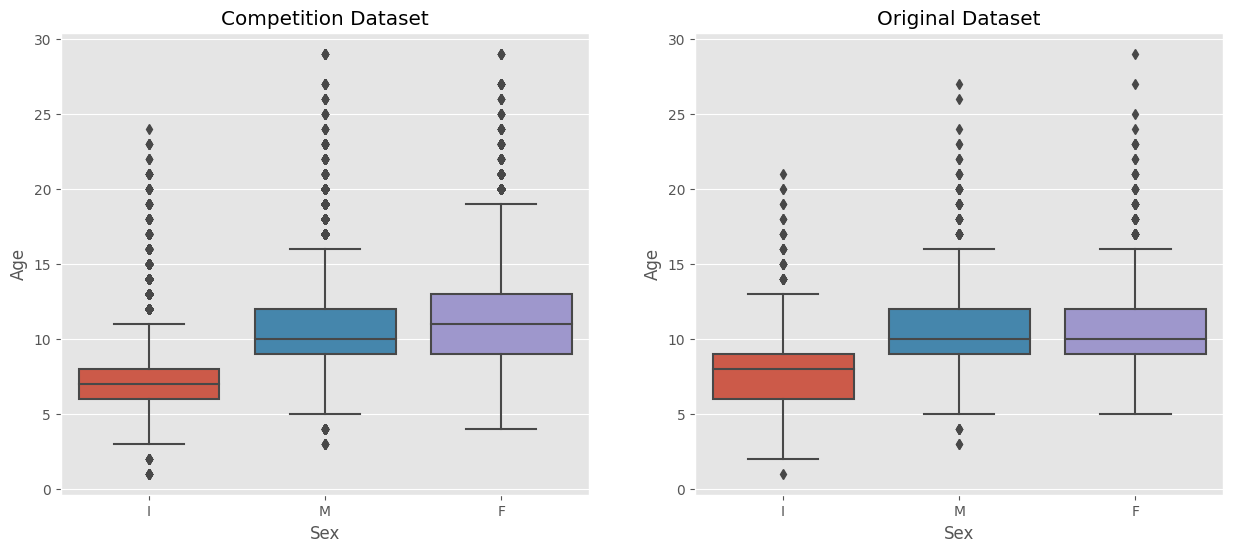

In [40]:
# sex컬럼을 범주형 데이터로 변환, I/M/F 순서의 범주를 가지도록 함(시각화용)
original['Sex'] = pd.Categorical(original['Sex'], categories = ['I', 'M', 'F'], ordered = True)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'Sex', y = 'Age').set_title('Competition Dataset')
sns.boxplot(ax = axes[1], data = original, x = 'Sex', y = 'Age').set_title('Original Dataset');

- shell 무게와 age의 상관관계 확인(양)

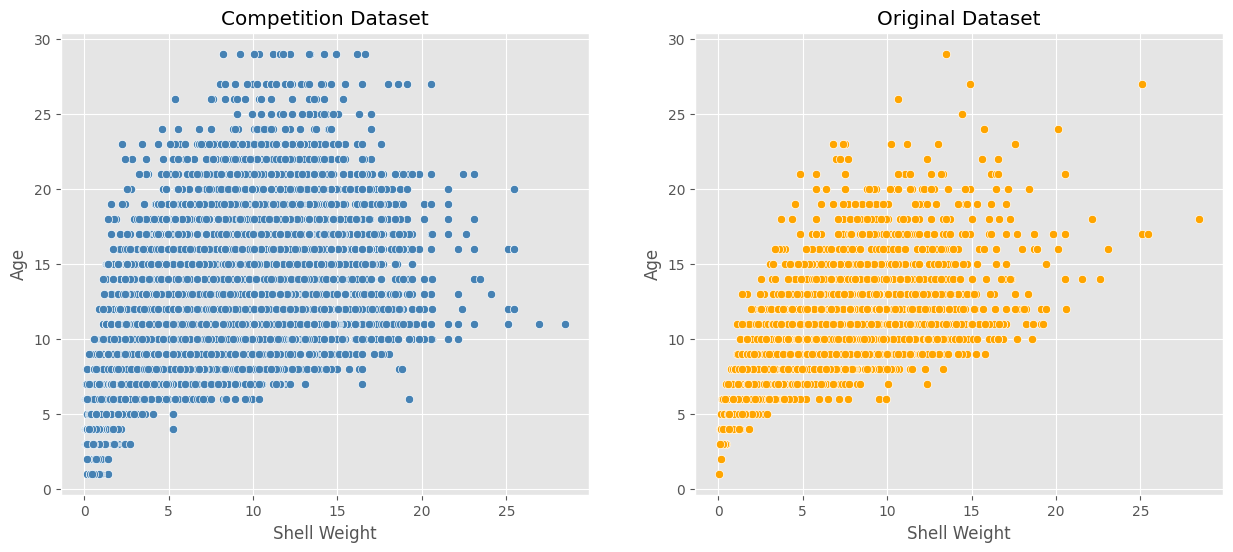

In [41]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = train, x = 'Shell Weight', y = 'Age', color = 'steelblue').set_title('Competition Dataset')
sns.scatterplot(ax = axes[1], data = original, x = 'Shell Weight', y = 'Age', color = 'orange').set_title('Original Dataset');

- diameter 와 age 간 선형 상관관계 확인

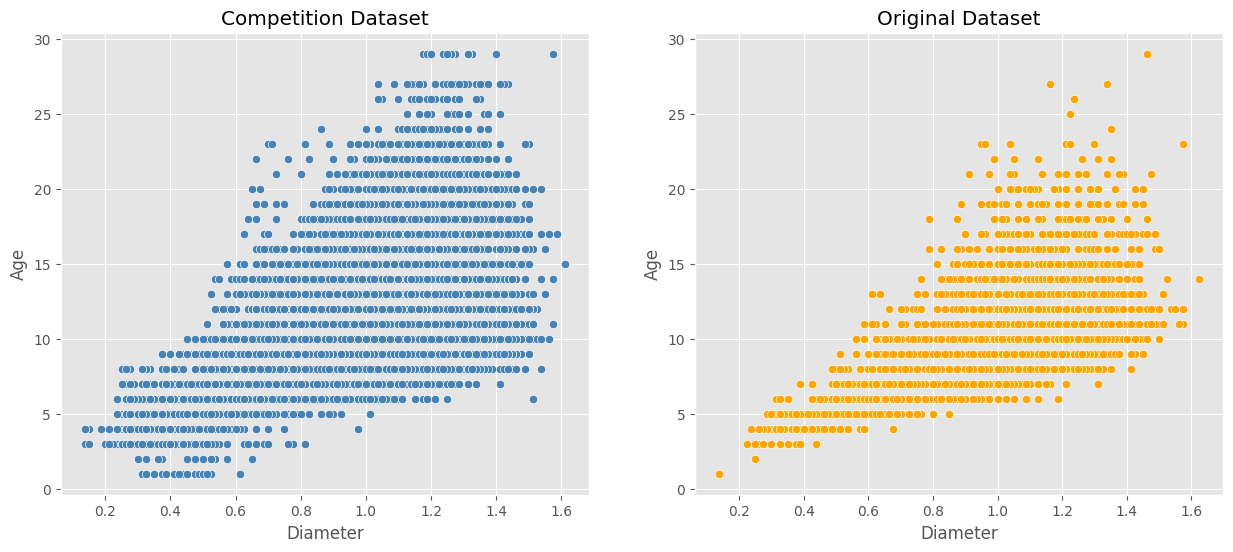

In [42]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = train, x = 'Diameter', y = 'Age', color = 'steelblue').set_title('Competition Dataset')
sns.scatterplot(ax = axes[1], data = original, x = 'Diameter', y = 'Age', color = 'orange').set_title('Original Dataset');

# Baseline Modeling 1.0

- train, original 데이터셋 합치기
- 성별을 라벨 인코딩하기

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train['generated'] = 1
original['generated'] = 0
test['generated'] = 1

In [44]:
train.drop(columns = 'id', axis = 1, inplace = True)

In [45]:
train = pd.concat([train, original], axis = 0).reset_index(drop = True)

In [46]:
train['Sex'] = le.fit_transform(train['Sex'])
train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,generated
0,1,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,1
1,1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,1
2,2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,1
3,0,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1
4,1,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,1


In [47]:
X = train.drop(columns = 'Age', axis = 1)
Y = train['Age']

In [48]:
test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['Sex'] = le.transform(test_baseline['Sex'])

# sex_mapping = {'I': 0, 'M': 1, 'F': 2}
# test_baseline['Sex'] = test_baseline['Sex'].map(sex_mapping)

In [49]:
test_baseline

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,generated
0,1,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552,1
1,1,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930,1
2,0,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415,1
3,0,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676,1
4,1,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066,1
...,...,...,...,...,...,...,...,...,...
49363,0,1.3000,1.0375,0.3250,16.315137,6.690482,5.173784,3.756309,1
49364,1,1.0375,0.7625,0.2625,10.276694,4.436697,1.998640,3.543687,1
49365,0,1.4875,1.1625,0.3625,31.382897,11.396499,6.846404,8.788345,1
49366,0,1.2375,0.9500,0.2875,15.663099,6.095142,3.727959,4.961163,1


In [50]:
gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

- kfold  & Gradient Boosting

In [51]:
skf = KFold(n_splits = 10, random_state = 42, shuffle = True)

#  Gradient Boosting

In [26]:
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    print(f'----------------------------------------------------------------')

    #Gradient Boosting
    gb_md = GradientBoostingRegressor(loss = 'absolute_error',
                                     n_estimators = 100,
                                     max_depth = 8,
                                     learning_rate = 0.01,
                                     min_samples_split = 10,
                                     min_samples_leaf = 20)
    gb_md.fit(X_train, Y_train)
    gb_pred_1 = gb_md.predict(X_test[X_test['generated'] == 1])
    gb_pred_2 = gb_md.predict(test_baseline)

    gb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], gb_pred_1)
    gb_preds.append(gb_score_fold)
    gb_preds.append(gb_pred_2)

    print('Fold', i, '-->> GradientBoosting of MAE is ---->>', gb_score_fold)

----------------------------------------------------------------
Fold 0 -->> GradientBoosting of MAE is ---->> 1.6003815249490325
----------------------------------------------------------------
Fold 1 -->> GradientBoosting of MAE is ---->> 1.6138275202624603
----------------------------------------------------------------
Fold 2 -->> GradientBoosting of MAE is ---->> 1.5905853161665873
----------------------------------------------------------------
Fold 3 -->> GradientBoosting of MAE is ---->> 1.58586072899156
----------------------------------------------------------------
Fold 4 -->> GradientBoosting of MAE is ---->> 1.5566191102721847
----------------------------------------------------------------
Fold 5 -->> GradientBoosting of MAE is ---->> 1.5515820711100174
----------------------------------------------------------------
Fold 6 -->> GradientBoosting of MAE is ---->> 1.638100822438253
----------------------------------------------------------------
Fold 7 -->> GradientBoosting

# Hist gradient boost

In [29]:
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    print(f'----------------------------------------------------------------')

    # histGradientBoosting

    hist_md = HistGradientBoostingRegressor(loss = 'absolute_error',
                                            l2_regularization = 0.01,
                                            early_stopping = False,
                                            learning_rate = 0.01,
                                            max_iter = 1000,
                                            max_depth = 15,
                                            max_bins = 255,
                                            min_samples_leaf = 70,
                                            max_leaf_nodes = 115)
    hist_md.fit(X_train, Y_train)

    hist_pred_1 = hist_md.predict(X_test[X_test['generated'] == 1])
    hist_pred_2 = hist_md.predict(test_baseline)
    hist_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], hist_pred_1)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)

    print('Fold', i, '==> HistGradient of MAE is ==>', hist_score_fold)

----------------------------------------------------------------
Fold 0 ==> HistGradient of MAE is ==> 1.3613121219042987
----------------------------------------------------------------
Fold 1 ==> HistGradient of MAE is ==> 1.3565219781539615
----------------------------------------------------------------
Fold 2 ==> HistGradient of MAE is ==> 1.358916513114261
----------------------------------------------------------------
Fold 3 ==> HistGradient of MAE is ==> 1.3424051305814382
----------------------------------------------------------------
Fold 4 ==> HistGradient of MAE is ==> 1.3397588435359904
----------------------------------------------------------------
Fold 5 ==> HistGradient of MAE is ==> 1.3387684023461919
----------------------------------------------------------------
Fold 6 ==> HistGradient of MAE is ==> 1.3908970974032784
----------------------------------------------------------------
Fold 7 ==> HistGradient of MAE is ==> 1.3753253866491697
-------------------------

# LGBM

In [25]:
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    print(f'----------------------------------------------------------------')

    # LGBM
    lgb_md = LGBMRegressor(objective = 'mae',
                           n_estimators = 1000,
                           max_depth = 15,
                           learning_rate = 0.01,
                           num_leaves = 105,
                           reg_alpha = 8,
                           reg_lambda = 3,
                           subsample = 0.6,
                           colsample_bytree = 0.8,
                           device = 'cpu',
                           force_col_wise=True)
    lgb_md.fit(X_train, Y_train)

    lgb_pred_1 = lgb_md.predict(X_test[X_test['generated'] == 1])
    lgb_pred_2 = lgb_md.predict(test_baseline)

    lgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], lgb_pred_1)
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)

    print('Fold', i, '==> LightGBM of MAE is ==>', lgb_score_fold)

----------------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 70149, number of used features: 9
[LightGBM] [Info] Start training from score 10.000000
Fold 0 ==> LightGBM of MAE is ==> 1.3571383830419057
----------------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 70149, number of used features: 9
[LightGBM] [Info] Start training from score 10.000000
Fold 1 ==> LightGBM of MAE is ==> 1.3551844603923613
----------------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 70149, 

# XGBoost

In [ ]:
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    print(f'----------------------------------------------------------------')

    # xgboost

    xgb_md = XGBRegressor(objective='reg:pseudohubererror',
                          tree_method = 'gpu_hist',
                          colsample_bytree = 0.9,
                          gamma = 0.65,
                          learning_rate = 0.01,
                          max_depth = 7,
                          min_child_weight = 20,
                          n_estimators = 1000,
                          subsample = 0.7).fit(X_train, Y_train)

    xgb_pred_1 = xgb_md.predict(X_test[X_test['generated'] == 1])
    xgb_pred_2 = xgb_md.predict(test_baseline)

    xgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], xgb_pred_1)
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)

    print('Fold', i, '==> XGBoost of MAE is ==>', xgb_score_fold)

# 전체 4개 모델

In [56]:
X = train.drop(columns = ['Age'], axis = 1)
Y = train['Age']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['Sex'] = le.transform(test_baseline['Sex'])

gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

skf = KFold(n_splits = 10, random_state = 42, shuffle = True)

for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    print('---------------------------------------------------------------')

    ######################
    ## GradientBoosting ##
    ######################
    gb_md = GradientBoostingRegressor(loss = 'absolute_error',
                                      n_estimators = 1000,
                                      max_depth = 8,
                                      learning_rate = 0.01,
                                      min_samples_split = 10,
                                      min_samples_leaf = 20).fit(X_train, Y_train)

    gb_pred_1 = gb_md.predict(X_test[X_test['generated'] == 1])
    gb_pred_2 = gb_md.predict(test_baseline)

    gb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)

    print('Fold', i, '==> GradientBoositng oof MAE is ==>', gb_score_fold)


    ##########################
    ## HistGradientBoosting ##
    ##########################
    hist_md = HistGradientBoostingRegressor(loss = 'absolute_error',
                                            l2_regularization = 0.01,
                                            early_stopping = False,
                                            learning_rate = 0.01,
                                            max_iter = 1000,
                                            max_depth = 15,
                                            max_bins = 255,
                                            min_samples_leaf = 70,
                                            max_leaf_nodes = 115).fit(X_train, Y_train)

    hist_pred_1 = hist_md.predict(X_test[X_test['generated'] == 1])
    hist_pred_2 = hist_md.predict(test_baseline)

    hist_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], hist_pred_1)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)

    print('Fold', i, '==> HistGradient oof MAE is ==>', hist_score_fold)

    ##############
    ## LightGBM ##
    ##############

    # lgb_md = LGBMRegressor(objective = 'mae',
    #                        n_estimators = 1000,
    #                        max_depth = 15,
    #                        learning_rate = 0.01,
    #                        num_leaves = 105,
    #                        reg_alpha = 8,
    #                        reg_lambda = 3,
    #                        subsample = 0.6,
    #                        colsample_bytree = 0.8,
    #                        device = 'gpu').fit(X_train, Y_train)

    # lgb_pred_1 = lgb_md.predict(X_test[X_test['generated'] == 1])
    # lgb_pred_2 = lgb_md.predict(test_baseline)

    # lgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], lgb_pred_1)
    # lgb_cv_scores.append(lgb_score_fold)
    # lgb_preds.append(lgb_pred_2)

    # print('Fold', i, '==> LightGBM oof MAE is ==>', lgb_score_fold)

    #############
    ## XGBoost ##
    #############

    xgb_md = XGBRegressor(objective = 'reg:pseudohubererror',
                          tree_method = 'exact',
                          colsample_bytree = 0.9,
                          gamma = 0.65,
                          learning_rate = 0.01,
                          max_depth = 7,
                          min_child_weight = 20,
                          n_estimators = 1000).fit(X_train, Y_train)

    xgb_pred_1 = xgb_md.predict(X_test[X_test['generated'] == 1])
    xgb_pred_2 = xgb_md.predict(test_baseline)

    xgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], xgb_pred_1)
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)

    print('Fold', i, '==> XGBoost oof MAE is ==>', xgb_score_fold)

---------------------------------------------------------------
Fold 0 ==> GradientBoositng oof MAE is ==> 1.3602794846827055
Fold 0 ==> HistGradient oof MAE is ==> 1.3613121219042987
Fold 0 ==> XGBoost oof MAE is ==> 1.3677360994394518
---------------------------------------------------------------
Fold 1 ==> GradientBoositng oof MAE is ==> 1.3559484314514705
Fold 1 ==> HistGradient oof MAE is ==> 1.3565219781539615
Fold 1 ==> XGBoost oof MAE is ==> 1.3663630641611486
---------------------------------------------------------------
Fold 2 ==> GradientBoositng oof MAE is ==> 1.356222117510458
Fold 2 ==> HistGradient oof MAE is ==> 1.358916513114261
Fold 2 ==> XGBoost oof MAE is ==> 1.3678182832072876
---------------------------------------------------------------
Fold 3 ==> GradientBoositng oof MAE is ==> 1.3458536375271009
Fold 3 ==> HistGradient oof MAE is ==> 1.3424051305814382
Fold 3 ==> XGBoost oof MAE is ==> 1.3539884446377888
------------------------------------------------------

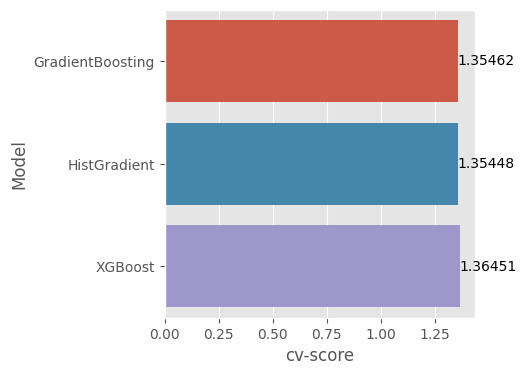

In [60]:
gb_cv_score = np.mean(gb_cv_scores)
hist_cv_score = np.mean(hist_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)

model_perf = pd.DataFrame({'Model':['GradientBoosting', 'HistGradient', 'XGBoost'],
                           'cv-score': [gb_cv_score, hist_cv_score, xgb_cv_score]})
plt.figure(figsize = (4, 4))
ax = sns.barplot(y = 'Model', x ='cv-score', data = model_perf)
ax.bar_label(ax.containers[0]);

# Baseline Modeling 2.0
- 피쳐 엔지니어링 수행
- catboost 사용

In [61]:
X = train.drop(columns = ['Age'], axis = 1)
Y = train['Age']

# train 독립변수에 대해 주요 파생변수 생성
X['Meat Yield'] = X['Shucked Weight'] / (X['Weight'] + X['Shell Weight'])
X['Shell Ratio'] = X['Shell Weight'] / X['Weight']
X['Weight_to_Shucked_Weight'] = X['Weight'] / X['Shucked Weight']
X['Viscera Ratio'] = X['Viscera Weight'] / X['Weight']

# test 데이터 정리 / 라벨 인코딩
test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['Sex'] = le.transform(test_baseline['Sex'])

# test 독립변수도 동일 파생변수 생성
test_baseline['Meat Yield'] = test_baseline['Shucked Weight'] / (test_baseline['Weight'] + test_baseline['Shell Weight'])
test_baseline['Shell Ratio'] = test_baseline['Shell Weight'] / test_baseline['Weight']
test_baseline['Weight_to_Shucked_Weight'] = test_baseline['Weight'] / test_baseline['Shucked Weight']
test_baseline['Viscera Ratio'] = test_baseline['Viscera Weight'] / test_baseline['Weight']



In [62]:
aml_cv_scores, aml_preds = list(), list()
gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
cat_cv_scores, cat_preds = list(), list()

ens_cv_scores_1, ens_preds_1 = list(), list()
ens_cv_scores_2, ens_preds_2 = list(), list()
ens_cv_scores_3, ens_preds_3 = list(), list()
ens_cv_scores_4, ens_preds_4 = list(), list()

In [67]:
skf = KFold(n_splits = 10, random_state = 42, shuffle = True)

for i, (train_ix, test_ix) in enumerate (skf.split(X, Y)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    print('---------------------------------------------------------------')

    ######################
    ## GradientBoosting ##
    ######################

    gb_features = ['Sex',
                   'Length',
                   'Diameter',
                   'Height',
                   'Weight',
                   'Shucked Weight',
                   'Viscera Weight',
                   'Shell Weight',
                   'generated']

    # 모델링에 사용할 주요 피쳐만 뽑아 저장
    X_train_gb = X_train[gb_features]
    X_test_gb = X_test[gb_features]
    test_baseline_gb = test_baseline[gb_features]

    gb_md = GradientBoostingRegressor(loss = 'absolute_error',
                                      n_estimators = 1000,
                                      max_depth = 8,
                                      learning_rate = 0.01,
                                      min_samples_split = 10,
                                      min_samples_leaf = 20,
                                      random_state = 42)
    gb_md.fit(X_train_gb, Y_train)

    gb_pred_1 = gb_md.predict(X_test_gb[X_test_gb['generated'] == 1])
    gb_pred_2 = gb_md.predict(test_baseline_gb)

    gb_score_fold = mean_absolute_error(Y_test[X_test_gb['generated'] == 1], gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)

    print('Fold', i, '==> GradientBoositng oof MAE is ==>', gb_score_fold)

    ##########################
    ## HistGradientBoosting ##
    ##########################

    hist_md = HistGradientBoostingRegressor(loss = 'absolute_error',
                                            l2_regularization = 0.01,
                                            early_stopping = False,
                                            learning_rate = 0.01,
                                            max_iter = 1000,
                                            max_depth = 15,
                                            max_bins = 255,
                                            min_samples_leaf = 70,
                                            max_leaf_nodes = 115,
                                            random_state = 42).fit(X_train, Y_train)

    hist_pred_1 = hist_md.predict(X_test[X_test['generated'] == 1])
    hist_pred_2 = hist_md.predict(test_baseline)

    hist_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], hist_pred_1)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)

    print('Fold', i, '==> HistGradient oof MAE is ==>', hist_score_fold)

    ##############
    ## LightGBM ##
    ##############

    lgb_md = LGBMRegressor(objective = 'mae',
                           n_estimators = 1000,
                           max_depth = 15,
                           learning_rate = 0.01,
                           num_leaves = 105,
                           reg_alpha = 8,
                           reg_lambda = 3,
                           subsample = 0.6,
                           colsample_bytree = 0.8,
                           random_state = 42).fit(X_train, Y_train)

    lgb_pred_1 = lgb_md.predict(X_test[X_test['generated'] == 1])
    lgb_pred_2 = lgb_md.predict(test_baseline)

    lgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], lgb_pred_1)
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)

    print('Fold', i, '==> LightGBM oof MAE is ==>', lgb_score_fold)

    #############
    ## XGBoost ##
    #############

    xgb_md = XGBRegressor(objective = 'reg:pseudohubererror',
                          tree_method = 'hist',
                          colsample_bytree = 0.9,
                          gamma = 0.65,
                          learning_rate = 0.01,
                          max_depth = 7,
                          min_child_weight = 20,
                          n_estimators = 1500,
                          subsample = 0.7,
                          random_state = 42).fit(X_train_gb, Y_train)

    xgb_pred_1 = xgb_md.predict(X_test_gb[X_test_gb['generated'] == 1])
    xgb_pred_2 = xgb_md.predict(test_baseline_gb)

    xgb_score_fold = mean_absolute_error(Y_test[X_test_gb['generated'] == 1], xgb_pred_1)
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)

    print('Fold', i, '==> XGBoost oof MAE is ==>', xgb_score_fold)

    ##############
    ## CatBoost ##
    ##############

    cat_features = ['Sex',
                    'Length',
                    'Diameter',
                    'Height',
                    'Weight',
                    'Shucked Weight',
                    'Viscera Weight',
                    'Shell Weight',
                    'generated',
                    'Meat Yield',
                    'Shell Ratio',
                    'Weight_to_Shucked_Weight']

    X_train_cat = X_train[cat_features]
    X_test_cat = X_test[cat_features]
    test_baseline_cat = test_baseline[cat_features]

    cat_md = CatBoostRegressor(loss_function = 'MAE',
                               iterations = 1000,
                               learning_rate = 0.08,
                               depth = 10,
                               random_strength = 0.2,
                               bagging_temperature = 0.7,
                               border_count = 254,
                               l2_leaf_reg = 0.001,
                               verbose = False,
                               grow_policy = 'Lossguide',
                               task_type = 'CPU',
                               random_state = 42).fit(X_train_cat, Y_train)

    cat_pred_1 = cat_md.predict(X_test_cat[X_test_cat['generated'] == 1])
    cat_pred_2 = cat_md.predict(test_baseline_cat)

    cat_score_fold = mean_absolute_error(Y_test[X_test_cat['generated'] == 1], cat_pred_1)
    cat_cv_scores.append(cat_score_fold)
    cat_preds.append(cat_pred_2)

    print('Fold', i, '==> CatBoost oof MAE is ==>', cat_score_fold)

---------------------------------------------------------------
Fold 0 ==> GradientBoositng oof MAE is ==> 1.3600831902284967
Fold 0 ==> HistGradient oof MAE is ==> 1.358525406691329
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 70149, number of used features: 13
[LightGBM] [Info] Start training from score 10.000000
Fold 0 ==> LightGBM oof MAE is ==> 1.3553085796410644
Fold 0 ==> XGBoost oof MAE is ==> 1.3660042263320271
Fold 0 ==> CatBoost oof MAE is ==> 1.360316135172595
---------------------------------------------------------------
Fold 1 ==> GradientBoositng oof MAE is ==> 1.3536029355660653
Fold 1 ==> HistGradient oof MAE is ==> 1.3558243763216642
[LightGBM] [Warning] Found whitespace in featur

In [69]:
    ##################
    ## LAD Ensemble ##
    ##################

    x = pd.DataFrame({'GBC': np.round(gb_pred_1.tolist()),  'hist': np.round(hist_pred_1.tolist()),
                      'lgb': np.round(lgb_pred_1.tolist()), 'xgb': np.round(xgb_pred_1.tolist()),
                      'cat': np.round(cat_pred_1.tolist())})
    y = Y_test[X_test['generated'] == 1]

    x_test = pd.DataFrame({'GBC': np.round(gb_pred_2.tolist()),  'hist': np.round(hist_pred_2.tolist()),
                           'lgb': np.round(lgb_pred_2.tolist()), 'xgb': np.round(xgb_pred_2.tolist()),
                           'cat': np.round(cat_pred_2.tolist())})

    lad_md_1 = LADRegression(fit_intercept = True, positive = False).fit(x, y)
    lad_md_2 = LADRegression(fit_intercept = True, positive = True).fit(x, y)
    lad_md_3 = LADRegression(fit_intercept = False, positive = True).fit(x, y)
    lad_md_4 = LADRegression(fit_intercept = False, positive = False).fit(x, y)

    lad_pred_1 = lad_md_1.predict(x)
    lad_pred_2 = lad_md_2.predict(x)
    lad_pred_3 = lad_md_3.predict(x)
    lad_pred_4 = lad_md_4.predict(x)

    lad_pred_test_1 = lad_md_1.predict(x_test)
    lad_pred_test_2 = lad_md_2.predict(x_test)
    lad_pred_test_3 = lad_md_3.predict(x_test)
    lad_pred_test_4 = lad_md_4.predict(x_test)

    ens_score_1 = mean_absolute_error(y, lad_pred_1)
    ens_cv_scores_1.append(ens_score_1)
    ens_preds_1.append(lad_pred_test_1)

    ens_score_2 = mean_absolute_error(y, lad_pred_2)
    ens_cv_scores_2.append(ens_score_2)
    ens_preds_2.append(lad_pred_test_2)

    ens_score_3 = mean_absolute_error(y, lad_pred_3)
    ens_cv_scores_3.append(ens_score_3)
    ens_preds_3.append(lad_pred_test_3)

    ens_score_4 = mean_absolute_error(y, lad_pred_4)
    ens_cv_scores_4.append(ens_score_4)
    ens_preds_4.append(lad_pred_test_4)

    print('Fold', i, '==> LAD Model 1 ensemble oof MAE is ==>', ens_score_1)
    print('Fold', i, '==> LAD Model 2 ensemble oof MAE is ==>', ens_score_2)
    print('Fold', i, '==> LAD Model 3 ensemble oof MAE is ==>', ens_score_3)
    print('Fold', i, '==> LAD Model 4 ensemble oof MAE is ==>', ens_score_4)

Fold 9 ==> LAD Model 1 ensemble oof MAE is ==> 1.3232173374416574
Fold 9 ==> LAD Model 2 ensemble oof MAE is ==> 1.3232173365707534
Fold 9 ==> LAD Model 3 ensemble oof MAE is ==> 1.3232173365704532
Fold 9 ==> LAD Model 4 ensemble oof MAE is ==> 1.3232173365819873


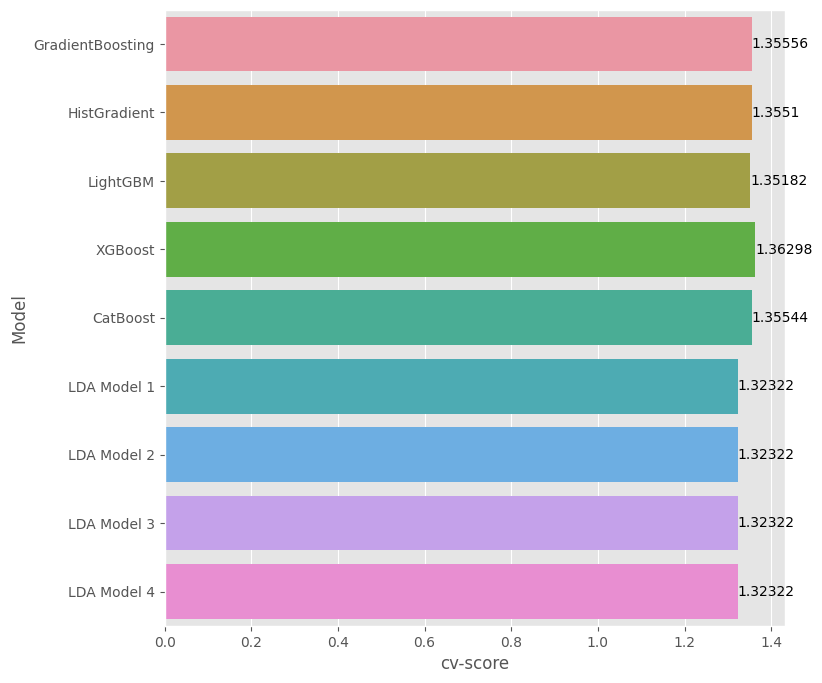

In [70]:
gb_cv_score = np.mean(gb_cv_scores)
hist_cv_score = np.mean(hist_cv_scores)
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
cat_cv_score = np.mean(cat_cv_scores)
ens_cv_score_1 = np.mean(ens_cv_scores_1)
ens_cv_score_2 = np.mean(ens_cv_scores_2)
ens_cv_score_3 = np.mean(ens_cv_scores_3)
ens_cv_score_4 = np.mean(ens_cv_scores_4)

model_perf = pd.DataFrame({'Model': ['GradientBoosting', 'HistGradient' ,'LightGBM', 'XGBoost', 'CatBoost',
                                     'LDA Model 1',
                                     'LDA Model 2',
                                     'LDA Model 3',
                                     'LDA Model 4'],
                           'cv-score': [gb_cv_score, hist_cv_score, lgb_cv_score, xgb_cv_score, cat_cv_score,
                                        ens_cv_score_1,
                                        ens_cv_score_2,
                                        ens_cv_score_3,
                                        ens_cv_score_4]})

plt.figure(figsize = (8, 8))
ax = sns.barplot(y = 'Model', x = 'cv-score', data = model_perf)
ax.bar_label(ax.containers[0]);

In [73]:
ens_preds_test_1 = pd.DataFrame(ens_preds_1)
ens_preds_test_1

,0,1,2,3,4,5,6,7,8,9,...,49358,49359,49360,49361,49362,49363,49364,49365,49366,49367
0,7.0,8.0,10.333334,9.0,7.666666,12.333333,11.0,8.0,12.666666,10.0,...,12.0,10.0,9.0,5.0,10.0,9.0,8.0,13.0,10.0,11.666666


In [74]:
ens_preds_test_1 = pd.DataFrame(ens_preds_1).apply(np.mean, axis = 0)
ens_preds_test_2 = pd.DataFrame(ens_preds_2).apply(np.mean, axis = 0)
ens_preds_test_3 = pd.DataFrame(ens_preds_3).apply(np.mean, axis = 0)
ens_preds_test_4 = pd.DataFrame(ens_preds_4).apply(np.mean, axis = 0)

submission['Age'] = round(ens_preds_test_1).astype(int)
submission.to_csv('LAD_Ensemble_model_1.csv', index = False)

submission['Age'] = round(ens_preds_test_2).astype(int)
submission.to_csv('LAD_Ensemble_model_2.csv', index = False)

submission['Age'] = round(ens_preds_test_3).astype(int)
submission.to_csv('LAD_Ensemble_model_3.csv', index = False)

submission['Age'] = round(ens_preds_test_4).astype(int)
submission.to_csv('LAD_Ensemble_model_4.csv', index = False)